In [157]:
"""main script for modelling"""

import logging
import configparser
import argparse
import warnings
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from src import utils
from src.modelling import transforms
from src.modelling import training
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [158]:
experiments = {}
model_names = ['linear_model']
n_tuning_trials = 10

## Baseline

In [159]:
experiment_name = 'baseline'
proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')

def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])

    

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=0.3, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results


[I 2024-04-05 00:39:56,521] A new study created in memory with name: no-name-b2f27e26-0b5b-42f6-8c2e-dfd9aa8e18d2


[I 2024-04-05 00:39:57,114] Trial 0 finished with value: -0.34192576350435033 and parameters: {'alpha': 1.3510953025380992}. Best is trial 0 with value: -0.34192576350435033.


Trial 0, alpha: 1.3510953025380992,  mape: 0.34192576350435033


[I 2024-04-05 00:39:57,668] Trial 1 finished with value: -0.34110110862110116 and parameters: {'alpha': 2.811007492269272}. Best is trial 1 with value: -0.34110110862110116.


Trial 1, alpha: 2.811007492269272,  mape: 0.34110110862110116


[I 2024-04-05 00:39:58,173] Trial 2 finished with value: -0.34114783808051635 and parameters: {'alpha': 2.7273413515406424}. Best is trial 1 with value: -0.34110110862110116.


Trial 2, alpha: 2.7273413515406424,  mape: 0.34114783808051635


[I 2024-04-05 00:39:58,775] Trial 3 finished with value: -0.34255091469984367 and parameters: {'alpha': 0.27227853213460046}. Best is trial 1 with value: -0.34110110862110116.


Trial 3, alpha: 0.27227853213460046,  mape: 0.34255091469984367


[I 2024-04-05 00:39:59,292] Trial 4 finished with value: -0.3424666591668367 and parameters: {'alpha': 0.41603264660875805}. Best is trial 1 with value: -0.34110110862110116.


Trial 4, alpha: 0.41603264660875805,  mape: 0.3424666591668367


[I 2024-04-05 00:39:59,797] Trial 5 finished with value: -0.3421584687692121 and parameters: {'alpha': 0.9460099140627773}. Best is trial 1 with value: -0.34110110862110116.


Trial 5, alpha: 0.9460099140627773,  mape: 0.3421584687692121


[I 2024-04-05 00:40:00,189] Trial 6 finished with value: -0.34196069284562464 and parameters: {'alpha': 1.2900670563591607}. Best is trial 1 with value: -0.34110110862110116.


Trial 6, alpha: 1.2900670563591607,  mape: 0.34196069284562464


[I 2024-04-05 00:40:00,613] Trial 7 finished with value: -0.3420991272801152 and parameters: {'alpha': 1.0490366089276184}. Best is trial 1 with value: -0.34110110862110116.


Trial 7, alpha: 1.0490366089276184,  mape: 0.3420991272801152


[I 2024-04-05 00:40:01,312] Trial 8 finished with value: -0.34263321292122717 and parameters: {'alpha': 0.13231410075762332}. Best is trial 1 with value: -0.34110110862110116.


Trial 8, alpha: 0.13231410075762332,  mape: 0.34263321292122717


[I 2024-04-05 00:40:01,923] Trial 9 finished with value: -0.34258604012949095 and parameters: {'alpha': 0.21248971184309465}. Best is trial 1 with value: -0.34110110862110116.


Trial 9, alpha: 0.21248971184309465,  mape: 0.34258604012949095
using tuned params
best score is: -0.34110110862110116
test score:0.18573981018695263
test score:0.18573981018695263


## Add trigonometric features

In [160]:

experiment_name = 'cyclical_features'
def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])

    

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                ("create_hour_sin",transforms.DerivedColumnTransformer(column_name='hour', 
                                                            new_column_name='hour_sin', 
                                                            derive_func=transforms.time_sin_transform,
                   
                                                            func_kwargs={'period':24})
                                                            ),
                ("create_hour_cos",transforms.DerivedColumnTransformer(column_name='hour', 
                                                            new_column_name='hour_cos', 
                                                            derive_func=transforms.time_cos_transform,
                                                            func_kwargs={'period':24})
                                                            ),
                ("create_month_sin",transforms.DerivedColumnTransformer(column_name='month', 
                                                            new_column_name='month_sin', 
                                                            derive_func=transforms.time_sin_transform,
                                                            func_kwargs={'period':12})
                                                            ),
                ("create_month_cos",transforms.DerivedColumnTransformer(column_name='month', 
                                                            new_column_name='month_cos', 
                                                            derive_func=transforms.time_cos_transform,
                                                            func_kwargs={'period':12})
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=0.3, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results


[I 2024-04-05 00:40:02,330] A new study created in memory with name: no-name-8a632c90-ef3b-4bf6-aee9-013f5408a59c
[I 2024-04-05 00:40:02,797] Trial 0 finished with value: -0.2995700081656107 and parameters: {'alpha': 1.3950281919995555}. Best is trial 0 with value: -0.2995700081656107.


Trial 0, alpha: 1.3950281919995555,  mape: 0.2995700081656107


[I 2024-04-05 00:40:03,836] Trial 1 finished with value: -0.2995760991941463 and parameters: {'alpha': 1.87007551629873}. Best is trial 0 with value: -0.2995700081656107.


Trial 1, alpha: 1.87007551629873,  mape: 0.2995760991941463


[I 2024-04-05 00:40:04,501] Trial 2 finished with value: -0.2995746857420679 and parameters: {'alpha': 1.7617980205111865}. Best is trial 0 with value: -0.2995700081656107.


Trial 2, alpha: 1.7617980205111865,  mape: 0.2995746857420679


[I 2024-04-05 00:40:04,987] Trial 3 finished with value: -0.29957298163915336 and parameters: {'alpha': 1.6304377860260493}. Best is trial 0 with value: -0.2995700081656107.


Trial 3, alpha: 1.6304377860260493,  mape: 0.29957298163915336


[I 2024-04-05 00:40:05,462] Trial 4 finished with value: -0.2995785754508529 and parameters: {'alpha': 2.05749606332286}. Best is trial 0 with value: -0.2995700081656107.


Trial 4, alpha: 2.05749606332286,  mape: 0.2995785754508529


[I 2024-04-05 00:40:05,915] Trial 5 finished with value: -0.2995943748949634 and parameters: {'alpha': 3.182274826390545}. Best is trial 0 with value: -0.2995700081656107.


Trial 5, alpha: 3.182274826390545,  mape: 0.2995943748949634


[I 2024-04-05 00:40:06,399] Trial 6 finished with value: -0.29957387953205455 and parameters: {'alpha': 1.6998167117800047}. Best is trial 0 with value: -0.2995700081656107.


Trial 6, alpha: 1.6998167117800047,  mape: 0.29957387953205455


[I 2024-04-05 00:40:06,908] Trial 7 finished with value: -0.29955928964144757 and parameters: {'alpha': 0.4267643944714526}. Best is trial 7 with value: -0.29955928964144757.


Trial 7, alpha: 0.4267643944714526,  mape: 0.29955928964144757


[I 2024-04-05 00:40:07,346] Trial 8 finished with value: -0.29955835992571345 and parameters: {'alpha': 0.32906564010654027}. Best is trial 8 with value: -0.29955835992571345.


Trial 8, alpha: 0.32906564010654027,  mape: 0.29955835992571345


[I 2024-04-05 00:40:07,867] Trial 9 finished with value: -0.299561284833252 and parameters: {'alpha': 0.6276801825483311}. Best is trial 8 with value: -0.29955835992571345.


Trial 9, alpha: 0.6276801825483311,  mape: 0.299561284833252
using tuned params
best score is: -0.29955835992571345
test score:0.18595037755715266
test score:0.18595037755715266


## Add higer order temperature

In [161]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import SplineTransformer

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
def periodic_spline_transformer(period, n_splines, degree):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )
categorical_column_names = ['hour', 'month']
# cyclic_spline_transformer = ColumnTransformer(
#     transformers=[
#         # ("categorical", one_hot_encoder, categorical_column_names),
#         ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
#         # ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
#         ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
#     ],
#     # remainder=MinMaxScaler(),
# )

In [162]:
n_tuning_trials = 10
experiment_name = 'higher_order_temperature'





def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    # daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])
    print(optimal_temperature_column_names)



    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                # ("create_hour_sin",transforms.DerivedColumnTransformer(column_name='hour', 
                #                                             new_column_name='hour_sin', 
                #                                             derive_func=transforms.time_sin_transform,
                   
                #                                             func_kwargs={'period':24})
                #                                             ),
                # ("create_hour_cos",transforms.DerivedColumnTransformer(column_name='hour', 
                #                                             new_column_name='hour_cos', 
                #                                             derive_func=transforms.time_cos_transform,
                #                                             func_kwargs={'period':24})
                #                                             ),
                # ("create_month_sin",transforms.DerivedColumnTransformer(column_name='month', 
                #                                             new_column_name='month_sin', 
                #                                             derive_func=transforms.time_sin_transform,
                #                                             func_kwargs={'period':12})
                #                                             ),
                # ("create_month_cos",transforms.DerivedColumnTransformer(column_name='month', 
                #                                             new_column_name='month_cos', 
                #                                             derive_func=transforms.time_cos_transform,
                #                                             func_kwargs={'period':12})
                #                                             ),

                # ("create_interaction_temp_hour",transforms.MultiColumnTransformer(column_names=['mean_temp', 'hour'], 
                #                                             new_column_name='temp_hour', 
                #                                             derive_func=transforms.multiply_columns)
                #                                             ),
                # ("create_interaction_hour_temp_sq",transforms.MultiColumnTransformer(column_names=['temp_sq', 'hour'], 
                #                                             new_column_name='temp_hour', 
                #                                             derive_func=transforms.multiply_columns)
                #                                             ),
                # ("create_interaction_temp_month",transforms.MultiColumnTransformer(column_names=['mean_temp', 'month'], 
                #                                             new_column_name='temp_month', 
                #                                             derive_func=transforms.multiply_columns)
                #                                             ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=0.3, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results

[I 2024-04-05 00:40:08,288] A new study created in memory with name: no-name-f0363090-0ed9-452e-bb5c-3617975db322


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 00:40:08,864] Trial 0 finished with value: -0.1146994925765219 and parameters: {'alpha': 0.14972072674750347}. Best is trial 0 with value: -0.1146994925765219.


Trial 0, alpha: 0.14972072674750347,  mape: 0.1146994925765219


[I 2024-04-05 00:40:09,412] Trial 1 finished with value: -0.11467432587181978 and parameters: {'alpha': 0.29340369087725043}. Best is trial 1 with value: -0.11467432587181978.


Trial 1, alpha: 0.29340369087725043,  mape: 0.11467432587181978


[I 2024-04-05 00:40:10,146] Trial 2 finished with value: -0.11420144656445304 and parameters: {'alpha': 3.192898340605058}. Best is trial 2 with value: -0.11420144656445304.


Trial 2, alpha: 3.192898340605058,  mape: 0.11420144656445304


[I 2024-04-05 00:40:10,776] Trial 3 finished with value: -0.11467736159263571 and parameters: {'alpha': 0.2760131702563999}. Best is trial 2 with value: -0.11420144656445304.


Trial 3, alpha: 0.2760131702563999,  mape: 0.11467736159263571


[I 2024-04-05 00:40:11,441] Trial 4 finished with value: -0.11409948215667216 and parameters: {'alpha': 3.871625792199739}. Best is trial 4 with value: -0.11409948215667216.


Trial 4, alpha: 3.871625792199739,  mape: 0.11409948215667216


[I 2024-04-05 00:40:12,093] Trial 5 finished with value: -0.11460221450965177 and parameters: {'alpha': 0.7095858108759034}. Best is trial 4 with value: -0.11409948215667216.


Trial 5, alpha: 0.7095858108759034,  mape: 0.11460221450965177


[I 2024-04-05 00:40:12,726] Trial 6 finished with value: -0.11452610293361272 and parameters: {'alpha': 1.1602340387989734}. Best is trial 4 with value: -0.11409948215667216.


Trial 6, alpha: 1.1602340387989734,  mape: 0.11452610293361272


[I 2024-04-05 00:40:13,232] Trial 7 finished with value: -0.11450571122756617 and parameters: {'alpha': 1.2824785356312756}. Best is trial 4 with value: -0.11409948215667216.


Trial 7, alpha: 1.2824785356312756,  mape: 0.11450571122756617


[I 2024-04-05 00:40:13,807] Trial 8 finished with value: -0.11405368040561166 and parameters: {'alpha': 4.186820519560398}. Best is trial 8 with value: -0.11405368040561166.


Trial 8, alpha: 4.186820519560398,  mape: 0.11405368040561166


[I 2024-04-05 00:40:14,297] Trial 9 finished with value: -0.11451107055849932 and parameters: {'alpha': 1.250330004218754}. Best is trial 8 with value: -0.11405368040561166.


Trial 9, alpha: 1.250330004218754,  mape: 0.11451107055849932
using tuned params
best score is: -0.11405368040561166
test score:0.09940206510985697
test score:0.09940206510985697


## Add season feature

[ 0  1  2  3  4  5  6  7  8  9 10 11] [ 2.14776703  1.15648994  0.34544505 -0.28536765 -0.73594814 -1.00629644
 -1.09641254 -1.00629644 -0.73594814 -0.28536765  0.34544505  1.15648994]


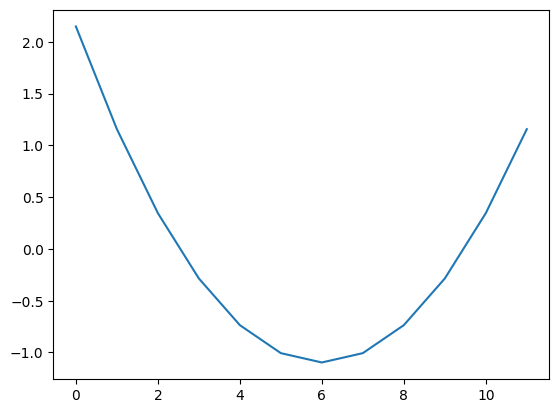

In [163]:
x = np.arange(0,12)
y = np.power( np.abs(6-x),2)
y = (y - np.mean(y))/ np.std(y)
plt.plot(x, y)
print(x, y)

In [164]:
experiment_name = 'seasonal_features'

def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    print(optimal_temperature_column_names)

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                # ("create_interaction_temp_hr",transforms.MultiColumnTransformer(column_names=['mean_temp', 'hour'], 
                #                                             new_column_name='temp_hour', 
                #                                             derive_func=transforms.multiply_columns)
                #                                             ),
                ("create_interaction_temp_month",transforms.MultiColumnTransformer(column_names=['mean_temp', 'month'], 
                                                            new_column_name='temp_month', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),
                ("create_month_season",transforms.DerivedColumnTransformer(column_name='month', 
                                                            new_column_name='month_season', 
                                                            derive_func=transforms.season_encode)
                                                            ),
                                                            
                ("create_interaction_month_season_hour",transforms.MultiColumnTransformer(column_names=['month_season', 'hour'], 
                                                            new_column_name='month_season_hour', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=0.3, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results
print(model_results)

['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 00:40:14,867] A new study created in memory with name: no-name-cecaaaed-4de6-4e64-b6ac-6a277d3ee0af
[I 2024-04-05 00:40:15,355] Trial 0 finished with value: -0.10857786783679287 and parameters: {'alpha': 2.9423326327714454}. Best is trial 0 with value: -0.10857786783679287.


Trial 0, alpha: 2.9423326327714454,  mape: 0.10857786783679287


[I 2024-04-05 00:40:15,914] Trial 1 finished with value: -0.11019943889196986 and parameters: {'alpha': 0.603005508920678}. Best is trial 0 with value: -0.10857786783679287.


Trial 1, alpha: 0.603005508920678,  mape: 0.11019943889196986


[I 2024-04-05 00:40:16,391] Trial 2 finished with value: -0.10864732279016043 and parameters: {'alpha': 2.815229780502454}. Best is trial 0 with value: -0.10857786783679287.


Trial 2, alpha: 2.815229780502454,  mape: 0.10864732279016043


[I 2024-04-05 00:40:16,869] Trial 3 finished with value: -0.10784521478609285 and parameters: {'alpha': 4.635027114217761}. Best is trial 3 with value: -0.10784521478609285.


Trial 3, alpha: 4.635027114217761,  mape: 0.10784521478609285


[I 2024-04-05 00:40:17,336] Trial 4 finished with value: -0.10975694379510656 and parameters: {'alpha': 1.1368857559825871}. Best is trial 3 with value: -0.10784521478609285.


Trial 4, alpha: 1.1368857559825871,  mape: 0.10975694379510656


[I 2024-04-05 00:40:17,808] Trial 5 finished with value: -0.11037819474724744 and parameters: {'alpha': 0.40305817379215364}. Best is trial 3 with value: -0.10784521478609285.


Trial 5, alpha: 0.40305817379215364,  mape: 0.11037819474724744


[I 2024-04-05 00:40:18,305] Trial 6 finished with value: -0.11060129089860962 and parameters: {'alpha': 0.16520599878246028}. Best is trial 3 with value: -0.10784521478609285.


Trial 6, alpha: 0.16520599878246028,  mape: 0.11060129089860962


[I 2024-04-05 00:40:18,785] Trial 7 finished with value: -0.11021308624481907 and parameters: {'alpha': 0.5874094396582052}. Best is trial 3 with value: -0.10784521478609285.


Trial 7, alpha: 0.5874094396582052,  mape: 0.11021308624481907


[I 2024-04-05 00:40:19,258] Trial 8 finished with value: -0.11062723358474018 and parameters: {'alpha': 0.13828226370127158}. Best is trial 3 with value: -0.10784521478609285.


Trial 8, alpha: 0.13828226370127158,  mape: 0.11062723358474018


[I 2024-04-05 00:40:19,725] Trial 9 finished with value: -0.11048594983225277 and parameters: {'alpha': 0.28671036963960533}. Best is trial 3 with value: -0.10784521478609285.


Trial 9, alpha: 0.28671036963960533,  mape: 0.11048594983225277
using tuned params
best score is: -0.10784521478609285
test score:0.10149250764273475
test score:0.10149250764273475
{'linear_model': (Pipeline(steps=[('select_optimal_temperature_columns',
                 OptimalTemperatureSelector(optimal_temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/optimal_temperature_columns.pkl'),
                                            temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/temperature_col...
                 MultiColumnTransformer(column_names=['month_season', 'hour'],
                                        derive_func=<function multiply_columns at 0x7f21d638a680>,
                                        new_column_name='month_season_hour')),
                ('one_hot_categorical_column',
                 ColumsOneHotEncoder(categorical_column_names=['hour',
         


## Add daily trend

In [165]:
experiment_name = 'trend'

def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    optimal_temperature_column_names = utils.load_value(optimal_temperature_column_names_path)
    print(optimal_temperature_column_names)

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_mean_temperature",transforms.DerivedColumnTransformer(column_name=optimal_temperature_column_names, 
                                                            new_column_name='mean_temp', 
                                                            derive_func=np.mean, func_kwargs={'axis':1})
                                                            ),
                
                ("create_temperature_squared",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_sq', 
                                                            derive_func=np.square)
                                                            ),
                ("create_temperature_cube",transforms.DerivedColumnTransformer(column_name='mean_temp', 
                                                            new_column_name='temp_cube', 
                                                            derive_func=transforms.exp_value, func_kwargs={'exp':3})
                                                            ),

                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                # ("create_interaction_temp_hr",transforms.MultiColumnTransformer(column_names=['mean_temp', 'hour'], 
                #                                             new_column_name='temp_hour', 
                #                                             derive_func=transforms.multiply_columns)
                #                                             ),
                ("create_interaction_temp_month",transforms.MultiColumnTransformer(column_names=['mean_temp', 'month'], 
                                                            new_column_name='temp_month', 
                                                            derive_func=transforms.multiply_columns)
                                                            ),
                ("create_trend",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='trend', 
                                                            derive_func=transforms.trend)
                                                            ),
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=0.3, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results


[I 2024-04-05 00:40:20,083] A new study created in memory with name: no-name-99759523-ea47-466a-842d-31f8ae6d5441


['t11', 't14', 't20', 't4', 't12', 't16']


[I 2024-04-05 00:40:20,550] Trial 0 finished with value: -0.1132308945480915 and parameters: {'alpha': 0.5726402014697402}. Best is trial 0 with value: -0.1132308945480915.


Trial 0, alpha: 0.5726402014697402,  mape: 0.1132308945480915


[I 2024-04-05 00:40:21,014] Trial 1 finished with value: -0.11321538657119763 and parameters: {'alpha': 1.3201243996775054}. Best is trial 1 with value: -0.11321538657119763.


Trial 1, alpha: 1.3201243996775054,  mape: 0.11321538657119763


[I 2024-04-05 00:40:21,475] Trial 2 finished with value: -0.11322972388331203 and parameters: {'alpha': 0.6244781297316816}. Best is trial 1 with value: -0.11321538657119763.


Trial 2, alpha: 0.6244781297316816,  mape: 0.11322972388331203


[I 2024-04-05 00:40:21,942] Trial 3 finished with value: -0.11323542177233628 and parameters: {'alpha': 0.3698041794055936}. Best is trial 1 with value: -0.11321538657119763.


Trial 3, alpha: 0.3698041794055936,  mape: 0.11323542177233628


[I 2024-04-05 00:40:22,400] Trial 4 finished with value: -0.11320886063620113 and parameters: {'alpha': 1.6990828553105695}. Best is trial 4 with value: -0.11320886063620113.


Trial 4, alpha: 1.6990828553105695,  mape: 0.11320886063620113


[I 2024-04-05 00:40:22,883] Trial 5 finished with value: -0.11319986262120776 and parameters: {'alpha': 3.989111838622354}. Best is trial 5 with value: -0.11319986262120776.


Trial 5, alpha: 3.989111838622354,  mape: 0.11319986262120776


[I 2024-04-05 00:40:23,345] Trial 6 finished with value: -0.11323642759305341 and parameters: {'alpha': 0.3241933290453756}. Best is trial 5 with value: -0.11319986262120776.


Trial 6, alpha: 0.3241933290453756,  mape: 0.11323642759305341


[I 2024-04-05 00:40:23,817] Trial 7 finished with value: -0.11319882034711934 and parameters: {'alpha': 3.8495167510140016}. Best is trial 7 with value: -0.11319882034711934.


Trial 7, alpha: 3.8495167510140016,  mape: 0.11319882034711934


[I 2024-04-05 00:40:24,276] Trial 8 finished with value: -0.11323384693482452 and parameters: {'alpha': 0.44119127401989877}. Best is trial 7 with value: -0.11319882034711934.


Trial 8, alpha: 0.44119127401989877,  mape: 0.11323384693482452


[I 2024-04-05 00:40:24,739] Trial 9 finished with value: -0.11323343462490351 and parameters: {'alpha': 0.45955097087457636}. Best is trial 7 with value: -0.11319882034711934.


Trial 9, alpha: 0.45955097087457636,  mape: 0.11323343462490351
using tuned params
best score is: -0.11319882034711934
test score:0.08923665864048742
test score:0.08923665864048742


## Add non-linear features

In [166]:
experiment_name = 'non-linear feature'
proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')

def make_pipeline():

    categorical_column_names = ['hour', 'month']
    columns_to_drop = ['date', 'hour', 'datetime']

    temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['temperature_columns'])
    optimal_temperature_column_names_path = proj_root.joinpath(config['modelling_paths']['optimal_temperature_columns'])
    daily_load_profile_path = proj_root.joinpath(config['modelling_paths']['daily_load_profile_feature'])

    

    pipeline = Pipeline(
            steps=[
                ("select_optimal_temperature_columns", transforms.OptimalTemperatureSelector(
                    temperature_column_names_path=temperature_column_names_path,
                    optimal_temperature_column_names_path=optimal_temperature_column_names_path)  
                ),
                ("create_weekend_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_weekend', 
                                                            derive_func=transforms.is_weekend)
                                                            ),
                ("create_month_col", transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='month', 
                                                            derive_func=transforms.get_month)
                                                            ),
                ("create_holiday_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='is_holiday', 
                                                            derive_func=transforms.is_holiday)
                                                            ),
                ("create_hour_col",transforms.DerivedColumnTransformer(column_name='datetime', 
                                                            new_column_name='hour', 
                                                            derive_func=transforms.get_hour)
                                                            ),
                # ("create_month_season",transforms.DerivedColumnTransformer(column_name='month', 
                #                                             new_column_name='month_season', 
                #                                             derive_func=transforms.season_encode)
                #                                             ),
                # ("create_non_linear_hour_features",transforms.HourlyProfileTransformer(datetime_column_name='datetime',
                #                                                                        feature_path=daily_load_profile_path)),                         
                ("one_hot_categorical_column", transforms.ColumsOneHotEncoder(categorical_column_names=categorical_column_names)),
                ('drop_columns', transforms.ColumnsRemover(column_names=columns_to_drop)),


            ]
        )
    return pipeline

def main(model_name:str, pipeline, n_tuning_trials=1):
    logger = logging.getLogger(__name__)
    proj_root = utils.get_proj_root()

    config = utils.get_config('config/config.ini')

    model_output_dir = proj_root.joinpath(config["modelling_paths"]["model_output"])
    preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])

    label_col_name = 'load'
    model_params = config._sections[model_name]
    model_class = training.get_model_class(model_name=model_name)
    model = model_class(**model_params)



    preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
    training_data, testing_data = train_test_split(preprocessed_data, test_size=0.3, shuffle=False)



    model_output_path = model_output_dir.joinpath(model_name + ".pkl")
    trainer = training.ModelTrainer(
        model_class=model,
        transform_pipeline=pipeline,
        training_data=training_data,
        testing_data=testing_data,
        label_col_name=label_col_name,
        model_output_path=model_output_path
    )

    logger.info("==============tuning started=============")
    trainer.tune_model(n_trials=n_tuning_trials)
    # logger.info('tuning completed')
    logger.info("==============training started====================")
    model = trainer.train_model(save_model=True)
    logger.info("==========training completed===============")
    logger.info("==========evaluation===============")
    score = trainer.evaluate_model()
    print(f"test score:{score}")
    logger.info(f"test score:{score}")
    score = trainer.inf_model()
    print(f"test score:{score}")
    logger.info(f"inf score:{score}")
    logger.info("==========evaluation completed===============")

    return model, score

model_results = {}

for model_name in model_names:

    pipeline = make_pipeline()
    model, score = main(model_name=model_name, pipeline=pipeline, n_tuning_trials=n_tuning_trials)
    model_results[model_name] = model, score

experiments[experiment_name] = model_results


[I 2024-04-05 00:40:25,091] A new study created in memory with name: no-name-4dfba19e-a71f-482a-b59c-1d0f4f2fa919
[I 2024-04-05 00:40:25,465] Trial 0 finished with value: -0.342230669186533 and parameters: {'alpha': 0.8211715889850644}. Best is trial 0 with value: -0.342230669186533.


Trial 0, alpha: 0.8211715889850644,  mape: 0.342230669186533


[I 2024-04-05 00:40:25,855] Trial 1 finished with value: -0.34199846737455325 and parameters: {'alpha': 1.2241968178684954}. Best is trial 1 with value: -0.34199846737455325.


Trial 1, alpha: 1.2241968178684954,  mape: 0.34199846737455325


[I 2024-04-05 00:40:26,265] Trial 2 finished with value: -0.34239660295990737 and parameters: {'alpha': 0.5358996384089731}. Best is trial 1 with value: -0.34199846737455325.


Trial 2, alpha: 0.5358996384089731,  mape: 0.34239660295990737


[I 2024-04-05 00:40:26,755] Trial 3 finished with value: -0.3424859894570399 and parameters: {'alpha': 0.3830064996596321}. Best is trial 1 with value: -0.34199846737455325.


Trial 3, alpha: 0.3830064996596321,  mape: 0.3424859894570399


[I 2024-04-05 00:40:27,198] Trial 4 finished with value: -0.3426433772946268 and parameters: {'alpha': 0.11505859298647797}. Best is trial 1 with value: -0.34199846737455325.


Trial 4, alpha: 0.11505859298647797,  mape: 0.3426433772946268


[I 2024-04-05 00:40:27,645] Trial 5 finished with value: -0.3426504673096858 and parameters: {'alpha': 0.10302564895609281}. Best is trial 1 with value: -0.34199846737455325.


Trial 5, alpha: 0.10302564895609281,  mape: 0.3426504673096858


[I 2024-04-05 00:40:28,041] Trial 6 finished with value: -0.3425880406685836 and parameters: {'alpha': 0.20908709949588639}. Best is trial 1 with value: -0.34199846737455325.


Trial 6, alpha: 0.20908709949588639,  mape: 0.3425880406685836


[I 2024-04-05 00:40:28,439] Trial 7 finished with value: -0.34250731618008523 and parameters: {'alpha': 0.3466090225449221}. Best is trial 1 with value: -0.34199846737455325.


Trial 7, alpha: 0.3466090225449221,  mape: 0.34250731618008523


[I 2024-04-05 00:40:28,872] Trial 8 finished with value: -0.34206150671719343 and parameters: {'alpha': 1.1144499333634035}. Best is trial 1 with value: -0.34199846737455325.


Trial 8, alpha: 1.1144499333634035,  mape: 0.34206150671719343


[I 2024-04-05 00:40:29,366] Trial 9 finished with value: -0.34194557666989783 and parameters: {'alpha': 1.3164710541659694}. Best is trial 9 with value: -0.34194557666989783.


Trial 9, alpha: 1.3164710541659694,  mape: 0.34194557666989783
using tuned params
best score is: -0.34194557666989783
test score:0.18585412526361272
test score:0.18585412526361272


In [167]:
exp_s = list(experiments.keys())
models_scores = {}
for model_name in model_names:
    models_scores[model_name] = []
    for exp in exp_s:
        exp_model_scores = experiments[exp]
        models_scores[model_name].append(exp_model_scores[model_name])

models_scores

{'linear_model': [(Pipeline(steps=[('select_optimal_temperature_columns',
                    OptimalTemperatureSelector(optimal_temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/optimal_temperature_columns.pkl'),
                                               temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/temperature_col...
                                             new_column_name='is_holiday')),
                   ('create_hour_col',
                    DerivedColumnTransformer(column_name='datetime',
                                             derive_func=<function get_hour at 0x7f21d638b880>,
                                             new_column_name='hour')),
                   ('one_hot_categorical_column',
                    ColumsOneHotEncoder(categorical_column_names=['hour',
                                                                  'month'])),
    

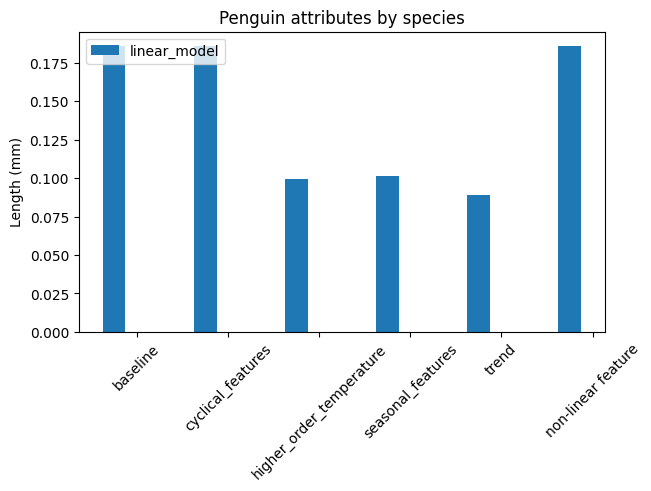

In [168]:
import matplotlib.pyplot as plt
import numpy as np

species = exp_s
penguin_means = models_scores

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for model_name, model_scores in penguin_means.items():
    scores = [model_score[1] for model_score in model_scores]
    offset = width * multiplier
    rects = ax.bar(x + offset, scores, width, label=model_name)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Length (mm)')
ax.set_title('Penguin attributes by species')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)
ax.tick_params(axis='x', labelrotation=45)
plt.show()

In [169]:
exp_s = list(experiments.keys())
models_scores = {}
for model_name in model_names:
    models_scores[model_name] = []
    for exp in exp_s:
        exp_model_scores = experiments[exp]
        models_scores[model_name].append(exp_model_scores[model_name])
models_scores

{'linear_model': [(Pipeline(steps=[('select_optimal_temperature_columns',
                    OptimalTemperatureSelector(optimal_temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/optimal_temperature_columns.pkl'),
                                               temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/temperature_col...
                                             new_column_name='is_holiday')),
                   ('create_hour_col',
                    DerivedColumnTransformer(column_name='datetime',
                                             derive_func=<function get_hour at 0x7f21d638b880>,
                                             new_column_name='hour')),
                   ('one_hot_categorical_column',
                    ColumsOneHotEncoder(categorical_column_names=['hour',
                                                                  'month'])),
    

In [170]:
models_best = {}
for model_name in model_names:
    model_scores = models_scores[model_name]
    scores = [model_score[1] for model_score in model_scores]
    models = [model_score[0] for model_score in model_scores]
    best_score = np.min(scores)
    best_model = models[np.argmin(scores)]
    models_best[model_name] = (best_model, best_score)
models_best

{'linear_model': (Pipeline(steps=[('select_optimal_temperature_columns',
                   OptimalTemperatureSelector(optimal_temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/optimal_temperature_columns.pkl'),
                                              temperature_column_names_path=PosixPath('/home/aroge/projects/electricity-demand-forecast/models/features/temperature_col...
                                          new_column_name='temp_month')),
                  ('create_trend',
                   DerivedColumnTransformer(column_name='datetime',
                                            derive_func=<function trend at 0x7f21d638a830>,
                                            new_column_name='trend')),
                  ('one_hot_categorical_column',
                   ColumsOneHotEncoder(categorical_column_names=['hour',
                                                                 'month'])),
                  ('dr

## Evaluation





transform


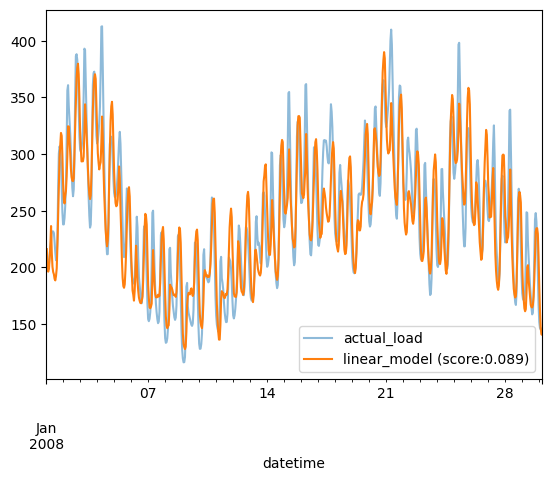

In [171]:
import pandas as pd
from src.preprocessing import preprocessing as prep
from src.inference import inference as inf
from src import utils

proj_root = utils.get_proj_root()

config = utils.get_config('config/config.ini')

# model_name = 'linear_model'


raw_temperature_data_path = utils.get_full_path(config['data_paths']['raw_temp_data'])
raw_temperature_data = pd.read_csv(raw_temperature_data_path, parse_dates=[0])
preprocessed_temperature_data = prep.TempDataPreprocessor().fit(raw_temperature_data).transform(raw_temperature_data)
inf_year = 2008
preprocessed_temperature_data = preprocessed_temperature_data[preprocessed_temperature_data.datetime.dt.year >= inf_year]
preprocessed_temperature_data = preprocessed_temperature_data.iloc[1:, :]  # includes first date not in eval
future_dates = preprocessed_temperature_data.datetime #+ p.to_timedelta(preprocessed_temperature_data.datetime.dt.hour, unit='h')



eval_data_path = config['data_paths']['evaluation_data']
actual_load = pd.read_csv(proj_root.joinpath(eval_data_path), parse_dates=[0])
actual_load = prep.LoadDataPreprocessor().fit(actual_load).transform(actual_load)

fig, ax = plt.subplots()
n_pts = 700
actual_load[:n_pts].plot(x='datetime', y='load', ax=ax, alpha=0.5, label="actual_load")
for i, model_name in enumerate(model_names):
    model, score = models_best[model_name]
    # model = inf.load_model(model_name=model_name)
    predicted_load = model.predict(preprocessed_temperature_data)

    prediction_data = pd.DataFrame({'datetime':future_dates, 'predicted_load':predicted_load})
# prediction_data.set_index('datetime', inplace=True)
    
    # if model_name == 'linear_model':
    #     continue
    
    prediction_data[:n_pts].plot(x='datetime', y='predicted_load', ls='-', ax=ax, alpha=1, label=f'{model_name} (score:{score:.3f})')

In [172]:
from src.modelling import training

proj_root = utils.get_proj_root()
config = utils.get_config('config/config.ini')
preprocessed_data_path = proj_root.joinpath(config['data_paths']['preprocessed_data'])
preprocessed_data = training.get_training_data(file_path=preprocessed_data_path)
preprocessed_data.head(2)


,load,datetime,t1,t2,t3,t4,t5,t6,t7,t8,...,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28
0,156.545,2005-01-01 01:00:00,43.0,46.0,40.0,47.0,48.0,46.0,44.0,52.0,...,39.0,50.0,43.0,45.0,50.0,47.0,41.0,47.0,47.0,45.0
1,147.924,2005-01-01 02:00:00,41.0,46.0,38.0,46.0,48.0,45.0,51.0,50.0,...,41.0,49.0,43.0,46.0,47.0,47.0,45.0,47.0,47.0,45.0
